In [1]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.transient_models.afterglow_models import tophat
from sklearn import preprocessing as pre
import scipy.constants as const
from sklearn.model_selection import GridSearchCV
import random
import pickle
from scipy import interpolate

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [94]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [95]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [96]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [97]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

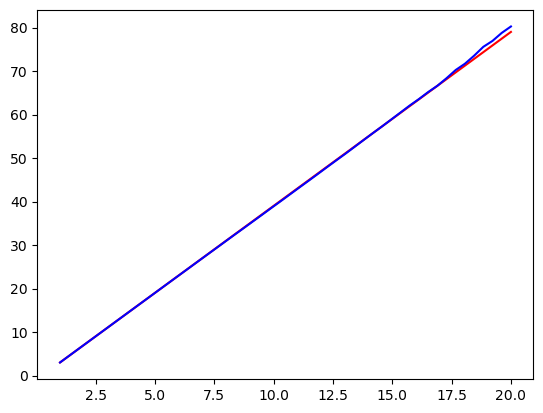

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [2]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [3]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [2]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=10000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)

NameError: name 'afterglow_constraints' is not defined

In [269]:
time = np.linspace(0.1, 300, 600) #xs
yvals = np.zeros((num, len(time)))  #ys

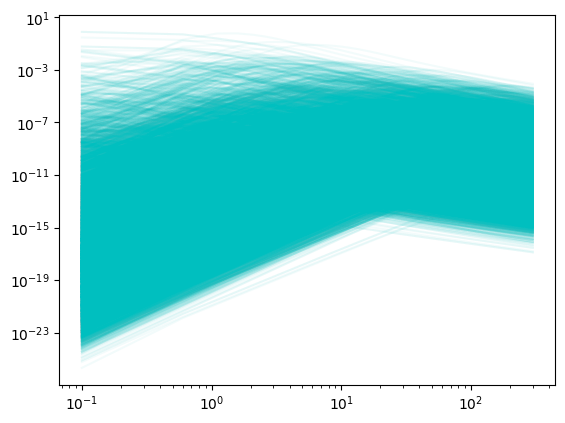

In [270]:
ax= plt.subplot()

for i in range(num):
    yvals[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, yvals[i], color='c', alpha=0.05)
plt.show()

In [290]:
X = afterglow_data.values
Y = yvals
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='sgd', learning_rate='adaptive').fit(X, Y)

In [291]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 600)

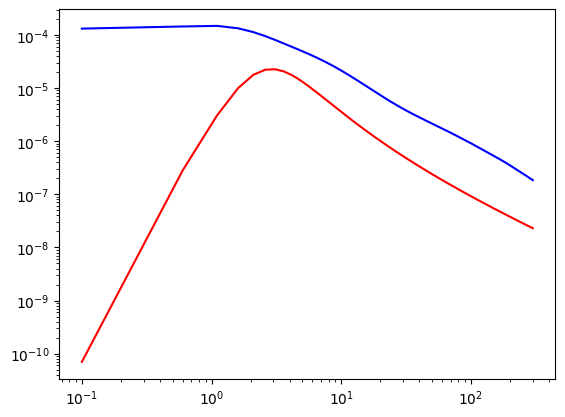

In [292]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue')#, ls='None', marker='x')
plt.show()

In [2]:
from redback.transient_models.afterglow_models import tophat_redback
def new_tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat_redback(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, xiN=1, g0=g0, frequency= frequency)
    return flux

In [18]:
def tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0,frequency):
    flux= tophat(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=1, g0=g0, frequency= frequency)
    return flux

In [3]:
general_priors= redback.priors.get_priors(model='tophat_redback')
#general_priors['frequency']= Uniform(minimum=1e13, maximum=2e15, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
frequency=[]
for f in range(9,18):
    rand_samples=(random.sample(range(10**f,10**(f+1)),10000))
    frequency.extend(rand_samples)

random.shuffle(frequency)
num=90000
tnum=100
samples=general_priors.sample(num)
samples['frequency']=frequency
tophat_data=pd.DataFrame.from_dict(samples)
unprocessed= pd.DataFrame.from_dict(samples)
tophat_data.drop('redshift', axis=1,inplace=True)
tophat_data.drop('xiN', axis=1,inplace=True)
unprocessed.drop('redshift', axis=1,inplace=True)
unprocessed.drop('xiN', axis=1,inplace=True)

tophat_data['thv']=np.log10(tophat_data['thv'])
tophat_data['thc']=np.log10(tophat_data['thc'])
tophat_data['g0']=np.log10(tophat_data['g0'])
tophat_data['frequency']=np.log10(tophat_data['frequency'])

min(unprocessed['frequency'])

1000580395

In [4]:
training = tophat_data.iloc[:(num-tnum)]
testing = tophat_data.iloc[(num-tnum):]


In [5]:
testing

,thv,loge0,thc,logn0,p,logepse,logepsb,g0,frequency
89900,-0.270675,44.052953,-1.531875,1.978550,2.551476,-1.628583,-4.652415,2.440332,11.977098
89901,-0.432567,47.695715,-1.128125,-4.820182,2.890805,-1.942304,-3.654914,2.907920,14.747168
89902,-0.437619,52.385584,-1.602834,-4.837137,2.073314,-3.872168,-0.006318,3.142582,14.537837
89903,0.175158,50.235691,-1.329820,0.577744,2.890770,-4.112396,-0.666788,2.955516,17.543014
89904,0.140219,52.859818,-1.313132,-3.183578,2.035676,-0.484303,-0.654418,2.526747,17.805081
...,...,...,...,...,...,...,...,...,...
89995,-0.281459,48.630914,-1.627892,-0.254322,2.796012,-2.847236,-1.507916,3.016353,17.958375
89996,0.010851,51.479849,-1.130231,-2.831418,2.933023,-2.723563,-0.024011,3.140256,15.769154
89997,0.143377,53.650175,-1.339424,-0.462860,2.175380,-1.199934,-1.138008,3.097947,14.741966
89998,-0.141626,45.675709,-1.360998,-1.103286,2.504416,-3.150381,-1.718952,2.136812,15.915166


In [16]:
time = np.linspace(0.1, 1, 10) #20 pints bewteen 0.1 and 1 day
time=np.insert(time,10,np.linspace(1.2,10,20))
time=np.insert(time,30,np.linspace(12,300,70))
len(time)

100

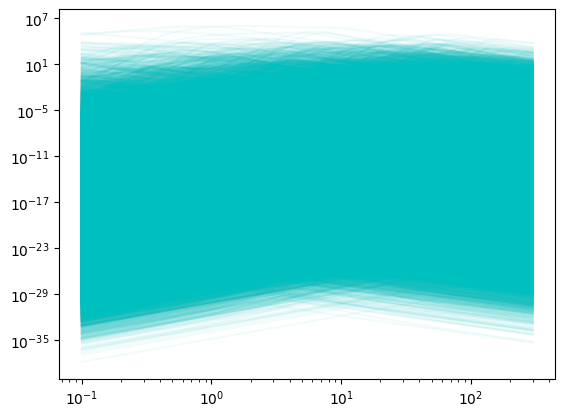

In [7]:
ys = np.zeros((num-tnum, len(time)))  #ys

ax= plt.subplot()

for i in range(num-tnum):
    ys[i]= new_tophat_func(time, **unprocessed.iloc[i])
    ax.loglog(time, ys[i], color='c', alpha=0.05)
plt.show()

In [10]:
np.save('yvals.npy',ys)

In [11]:
test=np.load('yvals.npy')
test==ys

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [12]:
scalerx = pre.StandardScaler()
scalery = pre.StandardScaler()
Y_train = scalery.fit_transform(np.log10(ys))
X_train = scalerx.fit_transform(training.values)
X_test= scalerx.transform(testing.values)

#params=np.array([0.5, 50.0 , 0.02, 1, 2.13,-1.25,-2.5, 1000])
#prediction = regr.predict(params.reshape(1,-1))


In [13]:
regressor = MLPRegressor(random_state=7, max_iter=1000, hidden_layer_sizes=(500,500,500), activation='relu',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-3, batch_size=128).fit(X_train, Y_train)

In [14]:
prediction = regressor.predict(X_test)
prediction = 10**(scalery.inverse_transform(prediction))
prediction.shape

(100, 100)

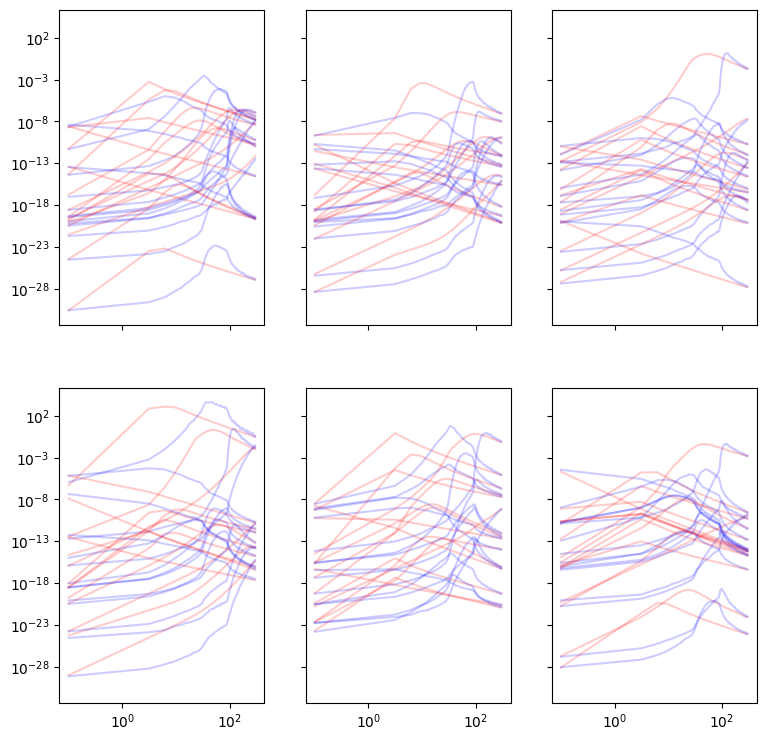

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,9), sharex=True, sharey=True)
time = np.linspace(0.1, 300, 100) #xs
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)

for i in range(15): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[0,0].loglog(time, true_value, color='red', alpha=0.2)
    ax[0,0].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(15,30): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[0,1].loglog(time, true_value, color='red', alpha=0.2)
    ax[0,1].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(30,45): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[1,0].loglog(time, true_value, color='red', alpha=0.2)
    ax[1,0].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(45,60): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[1,1].loglog(time, true_value, color='red', alpha=0.2)
    ax[1,1].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(60,75): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[0,2].loglog(time, true_value, color='red', alpha=0.2)
    ax[0,2].loglog(time, prediction[i], color='blue', alpha=0.2)
for i in range(75,90): 
    true_value= new_tophat_func(time, **unprocessed.iloc[i+(num-tnum)])
    ax[1,2].loglog(time, true_value, color='red', alpha=0.2)
    ax[1,2].loglog(time, prediction[i], color='blue', alpha=0.2)

#true_value= tophat_func(time, **unprocessed.iloc[2+(num-tnum)])
#ax[0,0].loglog(time, true_value, color='red', alpha=0.5)
#plt.savefig("emulation_final.png", dpi='figure')
plt.show()

In [11]:
with open("tophat.pkl", "wb") as f:
    pickle.dump(regr, f)

In [22]:
with open("improved_tophat.pkl", "wb") as file:
    pickle.dump(regressor, file)

In [ ]:
with open("tophat_redback.pkl", "wb") as file:
    pickle.dump(regressor, file)

In [7]:
with open("scalery.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("scalerx.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [33]:
with open("new_scalery.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("new_scalerx.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)
    

In [ ]:
with open("scalery_redback.pkl", "wb") as sy:
    pickle.dump(scalery, sy)
with open("scalerx_redback.pkl", "wb") as sx:
    pickle.dump(scalerx, sx)

In [29]:
params={}
params['thv']= np.log10(0.5)
params['loge0'] = 49.5
params['thc'] = np.log10(0.6)
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = np.log10(1000)
params['frequency']=np.log10(2e14)
test=np.fromiter(params.values(),dtype=float).reshape(1,-1)

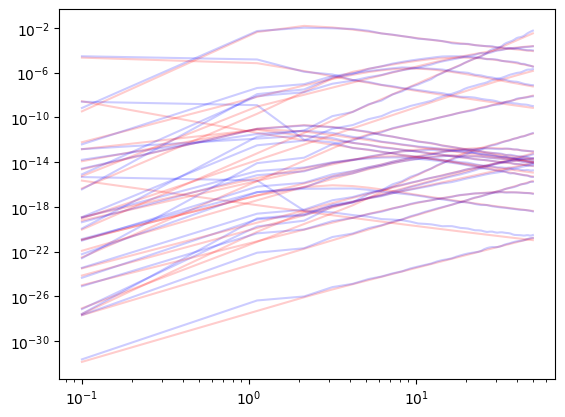

In [6]:
time=np.linspace(0.1,300,150)
with open("improved_tophat.pkl", "rb") as f:
    model = pickle.load(f)
with open("new_scalery.pkl", "rb") as sy:
    scalery = pickle.load(sy)
with open("new_scalerx.pkl", "rb") as sx:
    scalerx = pickle.load(sx) 

xtests= scalerx.transform(testing.values)
prediction= model.predict(xtests)
prediction = 10**(scalery.inverse_transform(prediction))

afterglow = interpolate.interp1d(time, prediction, kind='linear')
new_time= np.linspace(0.1,50,50)
fluxd= afterglow(new_time)

ax=plt.subplot()
for i in range(15,40):
    true_value= tophat_func(new_time, **unprocessed.iloc[i+(num-tnum)])
    ax.loglog(new_time, true_value, color='red', alpha=0.2)
    ax.loglog(new_time, fluxd[i], color='blue', alpha=0.2)
plt.show()

In [7]:
fluxd.shape

(100, 50)

In [15]:
prediction.shape

(100, 150)

In [21]:
xtests.shape

(100, 9)

In [38]:
unprocessed.iloc[2+(num-tnum)]

thv          1.122384e+00
loge0        5.159928e+01
thc          1.529868e-02
logn0       -1.734760e+00
p            2.967152e+00
logepse     -3.121768e-01
logepsb     -6.179132e-01
g0           5.168700e+02
frequency    6.516236e+14
Name: 79902, dtype: float64

In [39]:
unprocessed.iloc[11+(num-tnum)]

thv          6.543900e-02
loge0        4.983819e+01
thc          2.080898e-02
logn0       -3.140924e+00
p            2.251693e+00
logepse     -3.730114e+00
logepsb     -3.953608e+00
g0           2.132696e+02
frequency    3.087617e+17
Name: 79911, dtype: float64

In [75]:
unprocessed['frequency'].iloc[num-tnum:].values

array([1.00656140e+14, 1.06020086e+15, 1.29688986e+15, 1.12992999e+15,
       4.47437220e+14, 1.93297609e+15, 7.56629244e+14, 9.70446701e+14,
       1.17409372e+15, 1.41467503e+14, 4.49154818e+13, 7.81176125e+14,
       1.66962403e+15, 1.04042828e+15, 2.82502902e+14, 1.59135245e+15,
       1.80573842e+15, 1.26905363e+15, 1.26559804e+15, 1.52777522e+15,
       1.19898263e+15, 6.07214871e+14, 6.64438092e+14, 1.87507081e+15,
       2.52054190e+13, 3.56368518e+14, 1.29395306e+15, 4.69968628e+14,
       1.28224333e+15, 6.25654261e+14, 1.03705093e+14, 9.67024739e+14,
       1.24829321e+15, 1.94731382e+14, 1.24752724e+15, 7.51019582e+14,
       2.12234999e+14, 1.98934120e+15, 1.62828601e+15, 1.69866155e+14,
       4.20091907e+13, 1.41625790e+15, 1.71859143e+15, 1.50969322e+15,
       1.56926946e+15, 1.16343556e+15, 4.51808285e+14, 1.97380320e+14,
       3.56269372e+14, 1.60267180e+15, 9.03281048e+14, 1.46055184e+15,
       1.54683553e+15, 1.28757302e+15, 1.33752192e+14, 4.20890107e+14,
      

In [73]:
print(regr.n_iter_, regr.best_loss_)

73 0.005612029467075825


In [11]:
print(regr.n_iter_, regr.best_loss_)

38 0.0013669637969929973


In [14]:
print(regr.n_iter_, regr.best_loss_, regr.t_)

10 0.0014232664780402901 999000


In [12]:
param_grid={}
param_grid['hidden_layer_sizes']=[(500,500,500), (800,800,800)]
param_grid['activation']=['tanh','relu', 'logistic']
param_grid['solver']=['adam','sgd']
param_grid['batch_size']=[64, 128]
param_grid['learning_rate_init']=[0.001, 1e-4]

In [13]:
mlp = MLPRegressor(random_state=7, max_iter=1000)
tuner = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, verbose=3, pre_dispatch=3)
tuner.fit(X_train, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=adam;, score=0.996 total time= 1.5min
[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=adam;, score=0.997 total time= 1.8min
[CV 1/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.3min
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.2min
[CV 3/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.001, solver=sgd;, score=0.997 total time= 1.2min
[CV 2/3] END activation=tanh, batch_size=64, hidden_layer_sizes=(500, 500, 500), learning_rate_init=0.0001, solver=sgd;, score=0.993 total time= 4.0min
[CV 1/3] END activation=tanh,

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=1000, random_state=7),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'batch_size': [64, 128],
                         'hidden_layer_sizes': [(500, 500, 500),
                                                (800, 800, 800)],
                         'learning_rate_init': [0.001, 0.0001],
                         'solver': ['adam', 'sgd']},
             pre_dispatch=3, verbose=3)

In [20]:
tuner.best_score_

0.9987270022686235

In [19]:
tuner.best_params_

{'activation': 'relu',
 'batch_size': 64,
 'hidden_layer_sizes': (800, 800, 800),
 'learning_rate_init': 0.0001,
 'solver': 'adam'}

In [76]:
def power(frequency, g0, logepsb, logn0):
    me= const.m_e
    mp= const.m_p
    c= const.c
    sigma = const.sigma
    q=const.e
    n0= 10**(logn0)
    epsb= 10**(logepsb)
    constant = (me*(c**3)*sigma*((32*np.pi*mp)**0.5))/(3*q)

    pow= constant*(g0**2)*((epsb*n0)**0.5)*frequency*10e7 #power in ergs
    return pow

In [77]:
pprior = bilby.core.prior.PriorDict()
pprior['g0'] = bilby.core.prior.Uniform(100, 2000, 'g0')
pprior['logepsb'] = bilby.core.prior.Uniform(-5, 0, 'c')
pprior['logn0']=bilby.core.prior.Uniform(-5,2,'logn0')
pprior

{'g0': Uniform(minimum=100, maximum=2000, name='g0', latex_label='g0', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='c', latex_label='c', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='logn0', unit=None, boundary=None)}

In [78]:
N= 5000
samples=pprior.sample(N)
power_data=pd.DataFrame.from_dict(samples)
power_data

,g0,logepsb,logn0
0,185.380307,-2.711978,0.601665
1,1423.031101,-4.650265,1.992532
2,394.884171,-0.541732,-1.991962
3,1221.158402,-4.845642,1.404221
4,415.062706,-3.860507,-4.259996
...,...,...,...
4995,944.116862,-2.469384,-2.699051
4996,1360.925225,-1.993366,0.738621
4997,959.389273,-3.519324,1.084934
4998,797.601144,-0.752727,-0.088104


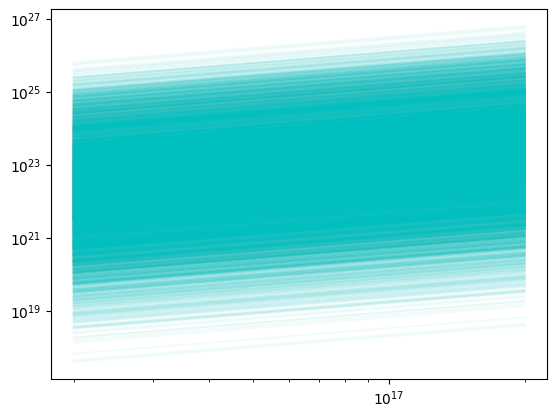

In [188]:
frequency = np.linspace(2e16, 2e17, 500) #xs
y = np.zeros((4900, len(frequency)))  #ys  

ax= plt.subplot()
for i in range(4900):
    y[i]= power(frequency, **power_data.iloc[i])
    ax.loglog(frequency, y[i], color='c', alpha=0.05)
plt.show()

In [196]:
y_train= y
scaler = pre.StandardScaler()
x_train=power_data.iloc[:4900].values
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 

x_test=power_data.iloc[4900:].values
x_test = scaler.transform(x_test)

regress = MLPRegressor(random_state=7, max_iter=2000, hidden_layer_sizes=(100,), activation='tanh',solver='sgd',learning_rate='adaptive', 
                       learning_rate_init=1e-5, batch_size= 16).fit(x_train, y_train)

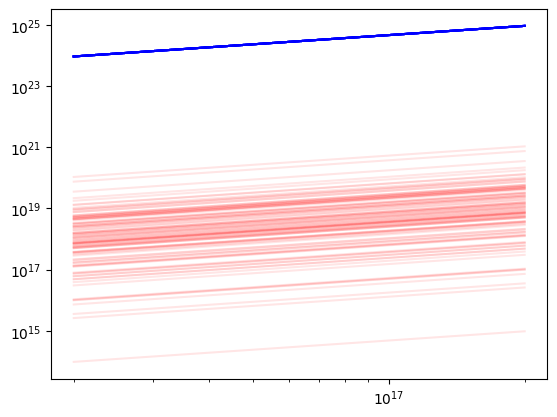

In [197]:
prediction = regress.predict(x_test)
#print(prediction)
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax2=plt.subplot()
for i in range(100): 
    true_value= power(frequency, *x_test[i])
    ax2.loglog(frequency, true_value, color='red', alpha=0.1)
    ax2.loglog(frequency, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
#plt.ylim(10e22,10e25)
plt.show()

In [2]:
from redback.simulate_transients import SimulateGenericTransient
times= np.linspace(0.1,40,100)
num_points=500
noise=0.05

bands = ['F160W', 'F110W','lssty', 'lsstz','lssti', 'lsstr','lsstg','lsstu', 'uvot::uvw1']
frequencies=[5e9, 2e17]
bandfreqs = (redback.utils.bands_to_frequency(bands))
print(bandfreqs)
frequencies.extend(bandfreqs)
frequencies.sort()
frequencies

model_kwargs = {'output_format':'flux_density', 'frequency':frequencies}

params={}
params['av'] = 0.5
params['loge0'] = 49.5
params['logn0'] = 0.5 
params['p'] = 2.3
params['logepse'] = -1.25
params['logepsb'] = -2.5
params['g0'] = 1000
params['thv']= 0.5
params['thc'] = 0.06
params['base_model']='tophat_from_emulator'
    
tophatag =  SimulateGenericTransient(model='extinction_with_afterglow_base_model', parameters=params,
                                            times=times, data_points=num_points, model_kwargs=model_kwargs, 
                                            multiwavelength_transient=True, noise_term=noise)
tophatag.data

[1.952e+14 2.601e+14 3.083e+14 3.454e+14 3.983e+14 4.825e+14 6.273e+14
 8.152e+14 1.141e+15]


,time,frequency,true_output,output,output_error
0,0.10000,2.000000e+17,9.310888e-13,9.418744e-13,4.655444e-14
1,0.10000,3.454000e+14,4.293809e-10,4.379203e-10,2.146905e-11
2,0.10000,5.000000e+09,8.815147e-11,8.649847e-11,4.407574e-12
3,0.10000,2.000000e+17,9.310888e-13,8.666881e-13,4.655444e-14
4,0.50303,2.000000e+17,2.310406e-08,2.378814e-08,1.155203e-09
...,...,...,...,...,...
495,40.00000,5.000000e+09,4.062142e-04,4.121116e-04,2.031071e-05
496,40.00000,6.273000e+14,1.011237e-07,1.009836e-07,5.056185e-09
497,40.00000,1.952000e+14,3.382322e-07,3.380945e-07,1.691161e-08
498,40.00000,2.000000e+17,1.752232e-09,1.814554e-09,8.761158e-11


Meta data does not exist for this event.


[4.10627441e-10 2.61571639e-07 2.28743801e-06 7.09015986e-06
 1.28219993e-05 1.68917857e-05 1.83640209e-05 1.78120805e-05
 1.61653271e-05 1.41510105e-05 1.21482624e-05 1.03507898e-05
 8.81548481e-06 7.53085429e-06 6.46787863e-06 5.59058093e-06
 4.86515860e-06 4.26316000e-06 3.76056890e-06 3.33841656e-06
 2.98151649e-06 2.67765802e-06 2.41742885e-06 2.19312659e-06
 1.99858953e-06 1.82894178e-06 1.68022576e-06 1.54919278e-06
 1.43318434e-06 1.32998131e-06 1.23778634e-06 1.15513330e-06
 1.08077058e-06 1.01361641e-06 9.52732946e-07 8.97382486e-07
 8.46932678e-07 8.00803699e-07 7.58503357e-07 7.19647975e-07
 6.83830318e-07 6.50764561e-07 6.20174260e-07 5.91796907e-07
 5.65453837e-07 5.40912805e-07 5.18044539e-07 4.96674520e-07
 4.76691838e-07 4.57958952e-07 4.40390521e-07 4.23871966e-07
 4.08343170e-07 3.93694850e-07 3.79887463e-07 3.66839550e-07
 3.54502360e-07 3.42823305e-07 3.31748504e-07 3.21250937e-07
 3.11279199e-07 3.01804169e-07 2.92784668e-07 2.84192241e-07
 2.76010037e-07 2.682021

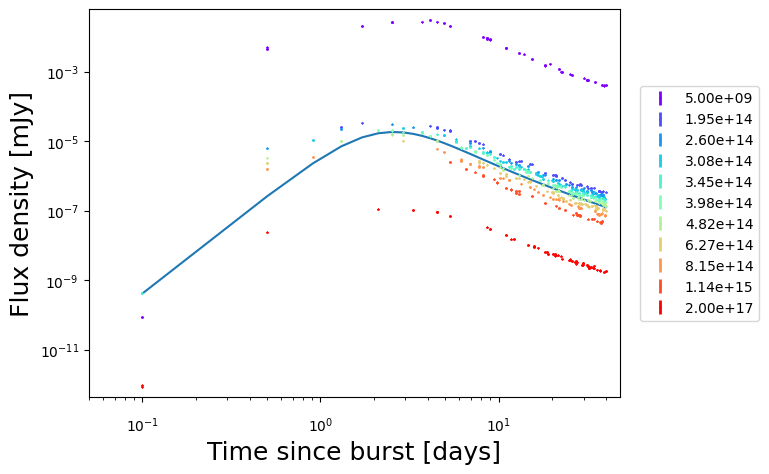

In [3]:
emulator_ag = redback.transient.Afterglow(name='afterglow_emulator', flux_density=tophatag.data['output'].values,
                                      time=tophatag.data['time'].values, data_mode='flux_density',
                                      flux_density_err=tophatag.data['output_error'].values, frequency=tophatag.data['frequency'].values)

ax=emulator_ag.plot_data(show=False)
flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(times, redshift=0.01, av=0.5,
        base_model='tophat',  thv= 0.5, loge0=49.5 , thc= 0.06, logn0=0.5, p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
        output_format='flux_density' , frequency=4.82e14)

ax.loglog(times, flux)
ax.loglog()
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.5))
plt.show()

In [10]:
model='tophat_from_emulator'
injection_parameters= params
model_kwargs = dict(frequency=emulator_ag.filtered_frequencies, output_format='flux_density')
priors = redback.priors.get_priors('tophat')
priors['redshift']=0.01
priors['ksin']=1
#priors['frequency']= Uniform(minimum=10e9, maximum=10e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
priors

{'redshift': 0.01,
 'thv': Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None),
 'loge0': Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None),
 'thc': Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None),
 'p': Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None),
 'logepse': Uniform(minimum=-5, maximum=0, name='logepse', latex_label='$\\log_{10}~\\epsilon_{e}$', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='logepsb', latex_label='$\\log_{10}~\\epsilon_{B}$', unit=None, boundary=None),
 'ksin': 1,
 'g0': Uniform(minimum=100, maximum=2000, nam

In [ ]:
emulator_result = redback.fit_model(transient=emulator_ag, model=model, sampler='dynesty', model_kwargs=model_kwargs,
                           prior=priors, sample='rslice', nlive=1000, plot=False, resume=False, injection_parameters=injection_parameters)


11:18 bilby INFO    : Running for label 'GRBafterglow_emulator', output will be saved to 'GRBData/afterglow/flux_density//tophat_from_emulator'
11:18 bilby INFO    : Analysis priors:
11:18 bilby INFO    : thv=Sine(minimum=0, maximum=1.5707963267948966, name='thv', latex_label='$\\theta_{\\mathrm{observer}}~(\\mathrm{rad})$', unit=None, boundary=None)
11:18 bilby INFO    : loge0=Uniform(minimum=44, maximum=54, name='loge0', latex_label='$\\log_{10}~E_{0}/{\\mathrm{erg}}$', unit=None, boundary=None)
11:18 bilby INFO    : thc=Uniform(minimum=0.01, maximum=0.1, name='thc', latex_label='$\\theta_{\\mathrm{core}}~({\\mathrm{rad}})$', unit=None, boundary=None)
11:18 bilby INFO    : logn0=Uniform(minimum=-5, maximum=2, name='logn0', latex_label='$\\log_{10}~n_{\\mathrm{ism}}/{\\mathrm{cm}}^{-3}$', unit=None, boundary=None)
11:18 bilby INFO    : p=Uniform(minimum=2, maximum=3, name='p', latex_label='$p$', unit=None, boundary=None)
11:18 bilby INFO    : logepse=Uniform(minimum=-5, maximum=0, nam

1it [00:00, ?it/s]

11:22 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/wfw23/anaconda3/envs/myenv/lib/python3.9/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
11:33 bilby INFO    : Written checkpoint file GRBData/afterglow/flux_density//tophat_from_emulator/GRBafterglow_emulator_resume.pickle
/home/wfw23/anacond